### Load required libraries and datasets

In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load data
filepath = "QVI_data (1).csv"
data = pd.read_csv(filepath)

### Select control stores

The client had selected store numbers 77, 86, and 88 as trial stores and had requested control stores to be identified—these should have been operational for the entire observation period. The aim was to match trial stores with control stores that exhibited similarity to the trial store's performance before the trial period (prior to Feb 2019). The criteria for similarity included:

- Monthly overall sales revenue

- Monthly number of customers

- Monthly number of transactions per customer

To initiate the process, I created the metrics of interest and filtered the stores that were operational throughout the pre-trial period.

In [2]:
# Convert 'DATE' column to datetime format
data['DATE'] = pd.to_datetime(data['DATE'])

# Create a month ID (YEARMONTH) column
data['YEARMONTH'] = data['DATE'].dt.year * 100 + data['DATE'].dt.month

data.dtypes

LYLTY_CARD_NBR               int64
DATE                datetime64[ns]
STORE_NBR                    int64
TXN_ID                       int64
PROD_NBR                     int64
PROD_NAME                   object
PROD_QTY                     int64
TOT_SALES                  float64
PACK_SIZE                    int64
BRAND                       object
LIFESTAGE                   object
PREMIUM_CUSTOMER            object
YEARMONTH                    int64
dtype: object

In [3]:
# Grouping data by 'STORE_NBR' and 'YEARMONTH', then calculating various measures
measureOverTime = data.groupby(['STORE_NBR', 'YEARMONTH']).agg(
    totSales=('TOT_SALES', 'sum'),
    nCustomers=('LYLTY_CARD_NBR', 'nunique'),
    nTxnPerCust=('TXN_ID', lambda x: x.nunique() / x.nunique()),
    nChipsPerTxn=('PROD_QTY', lambda x: x.sum() / x.nunique()),
    avgPricePerUnit=('TOT_SALES', lambda x: x.sum() / x.sum())
).reset_index()

# Sorting the resulting DataFrame by 'STORE_NBR' and 'YEARMONTH'
measureOverTime = measureOverTime.sort_values(by=['STORE_NBR', 'YEARMONTH'])
measureOverTime.head()

,STORE_NBR,YEARMONTH,totSales,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit
0,1,201807,206.9,49,1.0,31.0,1.0
1,1,201808,176.1,42,1.0,18.0,1.0
2,1,201809,278.8,59,1.0,37.5,1.0
3,1,201810,188.1,44,1.0,29.0,1.0
4,1,201811,192.6,46,1.0,28.5,1.0


In [4]:
# Identify stores with a full observation period (N = 12)
storesWithFullObs = measureOverTime.groupby('STORE_NBR').size().reset_index(name='N')
storesWithFullObs = storesWithFullObs[storesWithFullObs['N'] == 12]['STORE_NBR'].unique()

# Filter the pre-trial period (before February 2019) for stores with full observation periods
preTrialMeasures = measureOverTime[(measureOverTime['YEARMONTH'] < 201902) & (measureOverTime['STORE_NBR'].isin(storesWithFullObs))]
preTrialMeasures.head()

,STORE_NBR,YEARMONTH,totSales,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit
0,1,201807,206.9,49,1.0,31.0,1.0
1,1,201808,176.1,42,1.0,18.0,1.0
2,1,201809,278.8,59,1.0,37.5,1.0
3,1,201810,188.1,44,1.0,29.0,1.0
4,1,201811,192.6,46,1.0,28.5,1.0


I devised a method to calculate the correlation of performance between each potential control store and the trial store. Creating a function for this purpose streamlined the process, allowing me to avoid manual calculation for each trial store and control store pair.

In [5]:
# function to calculate correlation for a measure
def calculate_correlation(input_table, metric_col, store_comparison):
    calc_corr_table = pd.DataFrame(columns=['Store1', 'Store2', 'corr_measure'])

    store_numbers = input_table['STORE_NBR'].unique()

    for i in store_numbers:
        calculated_measure = pd.DataFrame({
            'Store1': [store_comparison],
            'Store2': [i],
            'corr_measure': [np.corrcoef(
                input_table.loc[input_table['STORE_NBR'] == store_comparison, metric_col],
                input_table.loc[input_table['STORE_NBR'] == i, metric_col]
            )[0, 1]]
        })

        calc_corr_table = calc_corr_table.append(calculated_measure, ignore_index=True)

    return calc_corr_table

In addition to correlation, I decided to calculate a standardized metric derived from the absolute difference between the trial store’s performance and the performance of each control store. I developed a function to compute this standardized metric for further analysis.

In [6]:
# Create a function to calculate a standardised magnitude distance for a measure,
def calculate_magnitude_distance(input_table, metric_col, store_comparison):
    calc_dist_table = pd.DataFrame(columns=['Store1', 'Store2', 'YEARMONTH', 'measure'])
    store_numbers = input_table['STORE_NBR'].unique()

    for i in store_numbers:
        calculated_measure = pd.DataFrame({
            'Store1': [store_comparison],
            'Store2': [i],
            'YEARMONTH': input_table.loc[input_table['STORE_NBR'] == store_comparison, 'YEARMONTH'].values[0],
            'measure': abs(input_table.loc[input_table['STORE_NBR'] == store_comparison, metric_col].values[0] -
                           input_table.loc[input_table['STORE_NBR'] == i, metric_col].values[0])
        })
        calc_dist_table = pd.concat([calc_dist_table, calculated_measure], ignore_index=True)

    min_max_dist = calc_dist_table.groupby(['Store1', 'YEARMONTH'])['measure'].agg(['min', 'max']).reset_index()
    dist_table = pd.merge(calc_dist_table, min_max_dist, on=['Store1', 'YEARMONTH'])
    dist_table['magnitudeMeasure'] = 1 - (dist_table['measure'] - dist_table['min']) / (dist_table['max'] - dist_table['min'])

    final_dist_table = dist_table.groupby(['Store1', 'Store2'])['magnitudeMeasure'].mean().reset_index()
    final_dist_table = final_dist_table.rename(columns={'magnitudeMeasure': 'mag_measure'})

    return final_dist_table

Next, I employed the functions to identify the control stores. The selection of control stores was based on the similarity of monthly total sales in dollar amounts and the monthly number of customers in comparison to the trial stores. Utilizing the functions, I obtained four scores, two for each criterion—total sales and total customers.

### Trial_store 77

In [77]:
# Define the trial store number
trial_store = 77

# Calculate correlation for total sales (totSales)
corr_nSales = calculate_correlation(preTrialMeasures, 'totSales', trial_store)

# Calculate correlation for number of customers (nCustomers)
corr_nCustomers = calculate_correlation(preTrialMeasures, 'nCustomers', trial_store)

# Calculate magnitude distance for total sales (totSales)
magnitude_nSales = calculate_magnitude_distance(preTrialMeasures, 'totSales', trial_store)

# Calculate magnitude distance for number of customers (nCustomers)
magnitude_nCustomers = calculate_magnitude_distance(preTrialMeasures, 'nCustomers', trial_store)

print('corr_nsales : ',corr_nSales)
print('corr_ncustomers: ',corr_nCustomers)
print('magnitude_nSales: ',magnitude_nSales)
print('magnitude_nCustomers: ',magnitude_nCustomers)

corr_nsales :      Store1 Store2  corr_measure
0       77      1      0.075218
1       77      2     -0.263079
2       77      3      0.806644
3       77      4     -0.263300
4       77      5     -0.110652
..     ...    ...           ...
255     77    268      0.344757
256     77    269     -0.315730
257     77    270      0.315430
258     77    271      0.355487
259     77    272      0.117622

[260 rows x 3 columns]
corr_ncustomers:      Store1 Store2  corr_measure
0       77      1      0.322168
1       77      2     -0.572051
2       77      3      0.834207
3       77      4     -0.295639
4       77      5      0.370659
..     ...    ...           ...
255     77    268      0.369517
256     77    269     -0.474293
257     77    270     -0.131259
258     77    271      0.019629
259     77    272      0.223217

[260 rows x 3 columns]
magnitude_nSales:       Store1  Store2  mag_measure
0        77       1     0.932426
1        77       2     0.890259
2        77       3     0.316822


I combined all the scores calculated using our function to create a composite score for ranking. I opted for a simple average of the correlation and magnitude scores for each driver. I considered adjusting the weight of the correlation score depending on our emphasis—increasing the weight for trend similarity or decreasing it for the absolute size of the drivers.

In [78]:
# Define the weights for correlation and magnitude
corr_weight = 0.5

# Merge correlation and magnitude DataFrames for total sales (totSales)
score_nSales = pd.merge(corr_nSales, magnitude_nSales, on=['Store1', 'Store2'])
score_nSales['scoreNSales'] = score_nSales['corr_measure'] * corr_weight + score_nSales['mag_measure'] * (1 - corr_weight)

# Merge correlation and magnitude DataFrames for number of customers (nCustomers)
score_nCustomers = pd.merge(corr_nCustomers, magnitude_nCustomers, on=['Store1', 'Store2'])
score_nCustomers['scoreNCust'] = score_nCustomers['corr_measure'] * corr_weight + score_nCustomers['mag_measure'] * (1 - corr_weight)
print(score_nCustomers)

    Store1 Store2  corr_measure  mag_measure  scoreNCust
0       77      1      0.322168     0.978947    0.650558
1       77      2     -0.572051     0.873684    0.150817
2       77      3      0.834207     0.357895    0.596051
3       77      4     -0.295639     0.189474   -0.053083
4       77      5      0.370659     0.557895    0.464277
..     ...    ...           ...          ...         ...
255     77    268      0.369517     0.968421    0.668969
256     77    269     -0.474293     0.452632   -0.010830
257     77    270     -0.131259     0.526316    0.197528
258     77    271      0.019629     0.526316    0.272972
259     77    272      0.223217     0.968421    0.595819

[260 rows x 5 columns]


After obtaining individual scores for both total number of sales and number of customers, I proceeded to merge the two scores by calculating a simple average.

In [79]:
# Merge scores for total sales and number of customers
score_Control = pd.merge(score_nSales, score_nCustomers, on=['Store1', 'Store2'])

# Calculate final combined control score
score_Control['finalControlScore'] = score_Control['scoreNSales'] * 0.5 + score_Control['scoreNCust'] * 0.5
print(score_Control)

    Store1 Store2  corr_measure_x  mag_measure_x  scoreNSales  corr_measure_y  \
0       77      1        0.075218       0.932426     0.503822        0.322168   
1       77      2       -0.263079       0.890259     0.313590       -0.572051   
2       77      3        0.806644       0.316822     0.561733        0.834207   
3       77      4       -0.263300       0.170851    -0.046224       -0.295639   
4       77      5       -0.110652       0.612748     0.251048        0.370659   
..     ...    ...             ...            ...          ...             ...   
255     77    268        0.344757       0.945280     0.645018        0.369517   
256     77    269       -0.315730       0.484967     0.084618       -0.474293   
257     77    270        0.315430       0.499399     0.407415       -0.131259   
258     77    271        0.355487       0.504059     0.429773        0.019629   
259     77    272        0.117622       0.897550     0.507586        0.223217   

     mag_measure_y  scoreNC

The store with the highest score is chosen as the control store because it exhibits the highest similarity to the trial store.

In [80]:
# Filter the scores for the trial store (store number 77)
#trial_store = 77
trial_store_scores = score_Control[score_Control['Store1'] == trial_store]

# Sort the scores in descending order of finalControlScore and select the second-highest store
control_store = trial_store_scores.sort_values(by='finalControlScore', ascending=False)['Store2'].iloc[1]
print(control_store)

233


Having found a control store, I proceeded to visually check if the drivers were indeed similar in the period before the trial. The initial focus was on examining the total sales during this period.

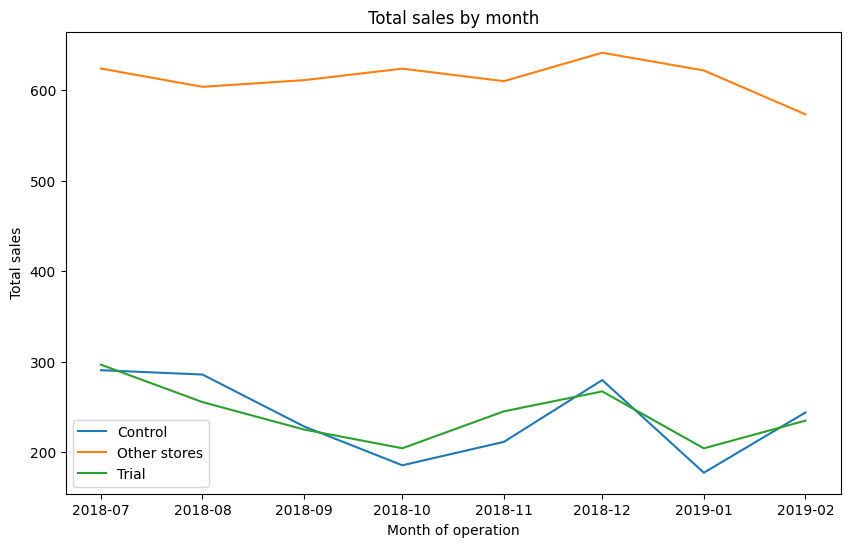

In [81]:
# Create a copy of the DataFrame
measureOverTimeSales = measureOverTime
measureOverTimeSales_copy = measureOverTime

# Assign Store_type based on trial_store and control_store
measureOverTimeSales_copy['Store_type'] = 'Other stores'
measureOverTimeSales_copy.loc[measureOverTimeSales_copy['STORE_NBR'] == trial_store, 'Store_type'] = 'Trial'
measureOverTimeSales_copy.loc[measureOverTimeSales_copy['STORE_NBR'] == control_store, 'Store_type'] = 'Control'

# Calculate mean total sales by YEARMONTH and Store_type
pastSales = measureOverTimeSales_copy.groupby(['YEARMONTH', 'Store_type'])['totSales'].mean().reset_index()

# Convert YEARMONTH to a readable date format
pastSales['TransactionMonth'] = pd.to_datetime(pastSales['YEARMONTH'], format='%Y%m')

# Filter data for dates before March 2019 (201903)
pastSales = pastSales[pastSales['YEARMONTH'] < 201903]

# Plotting the total sales trends
plt.figure(figsize=(10, 6))
for store_type, data in pastSales.groupby('Store_type'):
    plt.plot(data['TransactionMonth'], data['totSales'], label=store_type)

plt.xlabel('Month of operation')
plt.ylabel('Total sales')
plt.title('Total sales by month')
plt.legend()
plt.show()

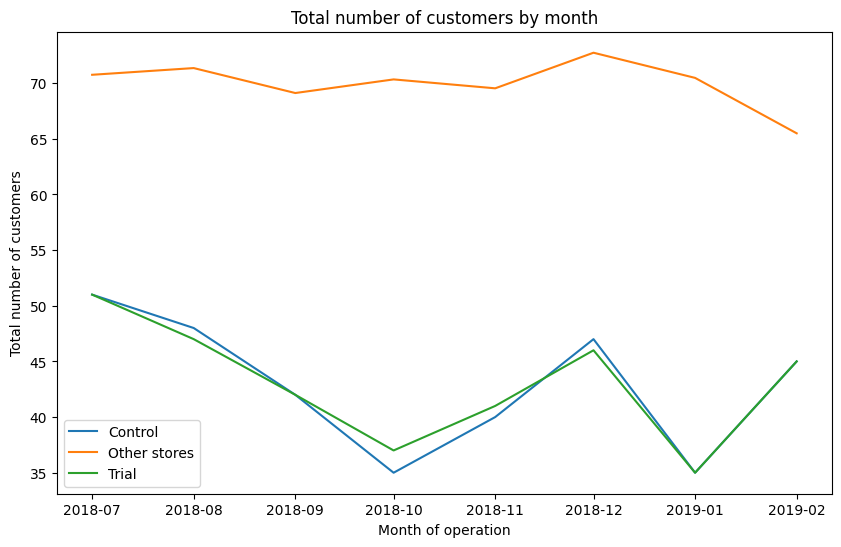

In [82]:
# Next, number of customers.

# Create a copy of the DataFrame
measureOverTimeCusts_copy = measureOverTime

# Assign Store_type based on trial_store and control_store
measureOverTimeCusts_copy['Store_type'] = 'Other stores'
measureOverTimeCusts_copy.loc[measureOverTimeCusts_copy['STORE_NBR'] == trial_store, 'Store_type'] = 'Trial'
measureOverTimeCusts_copy.loc[measureOverTimeCusts_copy['STORE_NBR'] == control_store, 'Store_type'] = 'Control'

# Calculate mean number of customers by YEARMONTH and Store_type
pastCustomers = measureOverTimeCusts_copy.groupby(['YEARMONTH', 'Store_type'])['nCustomers'].mean().reset_index()

# Convert YEARMONTH to a readable date format
pastCustomers['TransactionMonth'] = pd.to_datetime(pastCustomers['YEARMONTH'], format='%Y%m')

# Filter data for dates before March 2019 (201903)
pastCustomers = pastCustomers[pastCustomers['YEARMONTH'] < 201903]

# Plotting the total number of customers trends
plt.figure(figsize=(10, 6))
for store_type, data in pastCustomers.groupby('Store_type'):
    plt.plot(data['TransactionMonth'], data['nCustomers'], label=store_type)

plt.xlabel('Month of operation')
plt.ylabel('Total number of customers')
plt.title('Total number of customers by month')
plt.legend()
plt.show()


The trial period spanned from the beginning of March 2019 to June 2019. To assess any uplift in overall chip sales, I began by scaling the sales of the control store to a level similar to control for any discrepancies between the two stores outside of the trial period.

In [83]:
# Scale pre-trial control sales to match pre-trial trial store sales
scalingFactorForControlSales = (preTrialMeasures[(preTrialMeasures['STORE_NBR'] == trial_store) &
                                               (preTrialMeasures['YEARMONTH'] < 201902)]
                               ['totSales'].sum() /
                               preTrialMeasures[(preTrialMeasures['STORE_NBR'] == control_store) &
                                               (preTrialMeasures['YEARMONTH'] < 201902)]
                               ['totSales'].sum())

# Apply the scaling factor
measureOverTimeSales_copy = measureOverTime
scaledControlSales = (measureOverTimeSales_copy[measureOverTimeSales_copy['STORE_NBR'] == control_store]
                      .assign(controlSales=lambda x: x['totSales'] * scalingFactorForControlSales))
#print(scaledControlSales)

With comparable sales figures established for the control store, I proceeded to calculate the percentage difference between the scaled control sales and the trial store’s sales during the trial period.

In [84]:
# Filter measureOverTimeSales for trial_store and select columns totSales and YEARMONTH
trial_store_data = measureOverTimeSales[measureOverTimeSales['STORE_NBR'] == trial_store][['totSales', 'YEARMONTH']]

# Group by YEARMONTH and calculate percentage difference
trial_store_data_grouped = (trial_store_data.groupby('YEARMONTH')
                            .apply(lambda x: abs(scaledControlSales['controlSales'].values[0] - x['totSales']) /
                                          scaledControlSales['controlSales'].values[0])
                            .reset_index(name='percentageDiff'))
percentageDiff = trial_store_data_grouped

I examined whether the observed difference was statistically significant.

In [85]:
# Calculate Standard Deviation
stdDev = percentageDiff[percentageDiff['YEARMONTH'] < 201902]['percentageDiff'].std()

degreesOfFreedom = 7

# Calculate t-value for hypothesis testing
percentageDiff['tValue'] = (percentageDiff['percentageDiff'] - 0) / stdDev

# Convert YEARMONTH to TransactionMonth and filter for specific time periods
percentageDiff['TransactionMonth'] = pd.to_datetime(percentageDiff['YEARMONTH'] // 100 * 100 + percentageDiff['YEARMONTH'] % 100, format='%Y%m')

# Filter for TransactionMonths between January 2019 and April 2019 and select TransactionMonth and tValue
result = percentageDiff[(percentageDiff['YEARMONTH'] < 201905) & (percentageDiff['YEARMONTH'] > 201901)][['TransactionMonth', 'tValue']]
print(result)

  TransactionMonth    tValue
7       2019-02-01  1.840303
8       2019-03-01  0.560794
9       2019-04-01  1.002004


In [86]:
from scipy.stats import t

# Calculate the 95th percentile of the t-distribution
percentile_95 = t.ppf(0.95, df=degreesOfFreedom)
print(percentile_95)

1.894578605061305


I generated a more visual representation by plotting the sales of the control store, the sales of the trial stores, and the 95th percentile value of sales of the control store.

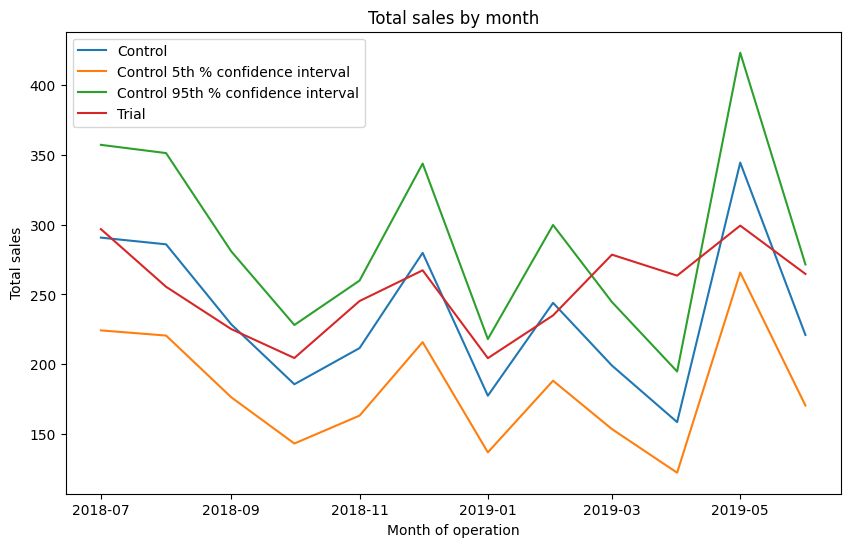

In [87]:
# Copy the measureOverTimeSales DataFrame
measureOverTimeSales = measureOverTime.copy()

# Calculate Store_type (Trial, Control, Other stores) and mean total sales per Store_type by YEARMONTH
measureOverTimeSales['Store_type'] = pd.np.where(measureOverTimeSales['STORE_NBR'] == trial_store, 'Trial',
                                                pd.np.where(measureOverTimeSales['STORE_NBR'] == control_store, 'Control',
                                                            'Other stores'))
pastSales = (measureOverTimeSales[measureOverTimeSales['Store_type'].isin(['Trial', 'Control'])]
             .groupby(['YEARMONTH', 'Store_type'])
             ['totSales'].mean().reset_index())

# Convert YEARMONTH to TransactionMonth for plotting
pastSales['TransactionMonth'] = pd.to_datetime(pastSales['YEARMONTH'] // 100 * 100 + pastSales['YEARMONTH'] % 100,
                                               format='%Y%m')

# Calculate 95th percentile and 5th percentile for Control store and add labels
pastSales_Controls95 = pastSales[pastSales['Store_type'] == 'Control'].copy()
pastSales_Controls95['totSales'] = pastSales_Controls95['totSales'] * (1 + stdDev * 2)
pastSales_Controls95['Store_type'] = 'Control 95th % confidence interval'

pastSales_Controls5 = pastSales[pastSales['Store_type'] == 'Control'].copy()
pastSales_Controls5['totSales'] = pastSales_Controls5['totSales'] * (1 - stdDev * 2)
pastSales_Controls5['Store_type'] = 'Control 5th % confidence interval'

# Combine the dataframes
trialAssessment = pd.concat([pastSales, pastSales_Controls95, pastSales_Controls5])

# Plotting using Matplotlib
plt.figure(figsize=(10, 6))

# Plot lines for different Store_type
for store_type, data in trialAssessment.groupby('Store_type'):
    plt.plot(data['TransactionMonth'], data['totSales'], label=store_type)

# Highlight the period from January 2019 to April 2019
plt.axvspan(pd.Timestamp('2019-01-01'), pd.Timestamp('2019-05-01'), ymin=0, ymax=float('inf'), color='gray', alpha=0.2)

# Customize plot
plt.xlabel('Month of operation')
plt.ylabel('Total sales')
plt.title('Total sales by month')
plt.legend()
plt.show()

The analysis indicated that during the trial period, the performance of store 77 significantly differed from its control store. Specifically, the trial store's performance fell outside the 5% to 95% confidence interval of the control store in two out of the three trial months. So, I proceeded to assess this pattern for the number of customers as well.

In [88]:
# Scale pre-trial control customers to match pre-trial trial store customers
scalingFactorForControlCust = (preTrialMeasures[(preTrialMeasures['STORE_NBR'] == trial_store) &
                                                (preTrialMeasures['YEARMONTH'] < 201902)]
                                ['nCustomers'].sum() /
                                preTrialMeasures[(preTrialMeasures['STORE_NBR'] == control_store) &
                                                (preTrialMeasures['YEARMONTH'] < 201902)]
                                ['nCustomers'].sum())

# Apply the scaling factor
measureOverTimeCusts = measureOverTime.copy()
scaledControlCustomers = (measureOverTimeCusts[measureOverTimeCusts['STORE_NBR'] == control_store]
                            .assign(controlCustomers=lambda x: x['nCustomers'] * scalingFactorForControlCust)
                            .assign(Store_type=lambda x: pd.np.where(x['STORE_NBR'] == trial_store, 'Trial',
                                                                      pd.np.where(x['STORE_NBR'] == control_store,
                                                                                  'Control', 'Other stores')))
                         )

# Calculate the percentage difference between scaled control customers and trial customers
percentageDiff = pd.merge(scaledControlCustomers[['YEARMONTH', 'controlCustomers']],
                          measureOverTimeCusts[measureOverTimeCusts['STORE_NBR'] == trial_store]
                            [['YEARMONTH', 'nCustomers']],
                          on='YEARMONTH')
percentageDiff['percentageDiff'] = abs(percentageDiff['controlCustomers'] - percentageDiff['nCustomers']) / percentageDiff['controlCustomers']

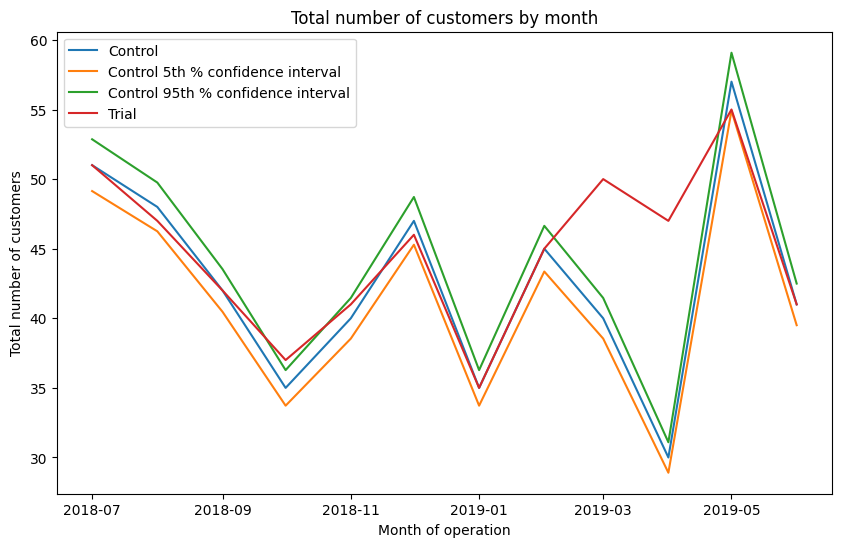

In [89]:
# Calculate standard deviation based on the scaled percentage difference in the pre-trial period
stdDev = percentageDiff[percentageDiff['YEARMONTH'] < 201902]['percentageDiff'].std()

# Set degrees of freedom
degreesOfFreedom = 7

# Copy the measureOverTimeSales DataFrame
measureOverTimeCusts = measureOverTime.copy()

# Calculate Store_type (Trial, Control, Other stores) and mean total sales per Store_type by YEARMONTH
measureOverTimeCusts['Store_type'] = pd.np.where(measureOverTimeCusts['STORE_NBR'] == trial_store, 'Trial',
                                                pd.np.where(measureOverTimeCusts['STORE_NBR'] == control_store, 'Control',
                                                            'Other stores'))
pastCustomers = (measureOverTimeCusts[measureOverTimeCusts['Store_type'].isin(['Trial', 'Control'])]
             .groupby(['YEARMONTH', 'Store_type'])
             ['nCustomers'].mean().reset_index())

# Convert YEARMONTH to TransactionMonth for plotting
pastCustomers['TransactionMonth'] = pd.to_datetime(pastCustomers['YEARMONTH'] // 100 * 100 + pastCustomers['YEARMONTH'] % 100,
                                               format='%Y%m')

# Calculate 95th percentile and 5th percentile for Control store and add labels
pastCustomers_Controls95 = pastCustomers[pastCustomers['Store_type'] == 'Control'].copy()
pastCustomers_Controls95['nCustomers'] = pastCustomers_Controls95['nCustomers'] * (1 + stdDev * 2)
pastCustomers_Controls95['Store_type'] = 'Control 95th % confidence interval'

pastCustomers_Controls5 = pastCustomers[pastCustomers['Store_type'] == 'Control'].copy()
pastCustomers_Controls5['nCustomers'] = pastCustomers_Controls5['nCustomers'] * (1 - stdDev * 2)
pastCustomers_Controls5['Store_type'] = 'Control 5th % confidence interval'

# Combine the dataframes
trialAssessment = pd.concat([pastCustomers, pastCustomers_Controls95, pastCustomers_Controls5])

# Plotting using Matplotlib
plt.figure(figsize=(10, 6))

# Plot lines for different Store_type
for store_type, data in trialAssessment.groupby('Store_type'):
    plt.plot(data['TransactionMonth'], data['nCustomers'], label=store_type)

# Highlight the period from January 2019 to April 2019
plt.axvspan(pd.Timestamp('2019-01-01'), pd.Timestamp('2019-05-01'), ymin=0, ymax=float('inf'), color='gray', alpha=0.2)

# Customize plot
plt.xlabel('Month of operation')
plt.ylabel('Total number of customers')
plt.title('Total number of customers by month')
plt.legend()
plt.show()

### Trial_store 86

In [25]:
# Define the trial store number
trial_store = 86

# Calculate correlation for total sales (totSales)
corr_nSales = calculate_correlation(preTrialMeasures, 'totSales', trial_store)

# Calculate correlation for number of customers (nCustomers)
corr_nCustomers = calculate_correlation(preTrialMeasures, 'nCustomers', trial_store)

# Calculate magnitude distance for total sales (totSales)
magnitude_nSales = calculate_magnitude_distance(preTrialMeasures, 'totSales', trial_store)

# Calculate magnitude distance for number of customers (nCustomers)
magnitude_nCustomers = calculate_magnitude_distance(preTrialMeasures, 'nCustomers', trial_store)

print('corr_nsales : ',corr_nSales)
print('corr_ncustomers: ',corr_nCustomers)
print('magnitude_nSales: ',magnitude_nSales)
print('magnitude_nCustomers: ',magnitude_nCustomers)

corr_nsales :      Store1 Store2  corr_measure
0       86      1      0.445632
1       86      2     -0.403835
2       86      3     -0.261284
3       86      4     -0.039035
4       86      5      0.235159
..     ...    ...           ...
255     86    268     -0.452182
256     86    269      0.697055
257     86    270     -0.730679
258     86    271      0.527637
259     86    272      0.004926

[260 rows x 3 columns]
corr_ncustomers:      Store1 Store2  corr_measure
0       86      1      0.485831
1       86      2     -0.086161
2       86      3     -0.353786
3       86      4     -0.169608
4       86      5     -0.253229
..     ...    ...           ...
255     86    268     -0.034273
256     86    269     -0.098587
257     86    270     -0.767267
258     86    271      0.267393
259     86    272     -0.353815

[260 rows x 3 columns]
magnitude_nSales:       Store1  Store2  mag_measure
0        86       1     0.226524
1        86       2     0.163205
2        86       3     0.646163


I combined all the scores calculated using our function to create a composite score for ranking. I opted for a simple average of the correlation and magnitude scores for each driver. I considered adjusting the weight of the correlation score depending on our emphasis—increasing the weight for trend similarity or decreasing it for the absolute size of the drivers.

In [26]:
# Define the weights for correlation and magnitude
corr_weight = 0.5

# Merge correlation and magnitude DataFrames for total sales (totSales)
score_nSales = pd.merge(corr_nSales, magnitude_nSales, on=['Store1', 'Store2'])
score_nSales['scoreNSales'] = score_nSales['corr_measure'] * corr_weight + score_nSales['mag_measure'] * (1 - corr_weight)

# Merge correlation and magnitude DataFrames for number of customers (nCustomers)
score_nCustomers = pd.merge(corr_nCustomers, magnitude_nCustomers, on=['Store1', 'Store2'])
score_nCustomers['scoreNCust'] = score_nCustomers['corr_measure'] * corr_weight + score_nCustomers['mag_measure'] * (1 - corr_weight)
print(score_nCustomers)

    Store1 Store2  corr_measure  mag_measure  scoreNCust
0       86      1      0.485831     0.484536    0.485184
1       86      2     -0.086161     0.381443    0.147641
2       86      3     -0.353786     0.865979    0.256097
3       86      4     -0.169608     0.701031    0.265711
4       86      5     -0.253229     0.938144    0.342458
..     ...    ...           ...          ...         ...
255     86    268     -0.034273     0.474227    0.219977
256     86    269     -0.098587     0.958763    0.430088
257     86    270     -0.767267     0.969072    0.100902
258     86    271      0.267393     0.969072    0.618233
259     86    272     -0.353815     0.474227    0.060206

[260 rows x 5 columns]


After obtaining individual scores for both total number of sales and number of customers, I proceeded to merge the two scores by calculating a simple average.

In [27]:
# Merge scores for total sales and number of customers
score_Control = pd.merge(score_nSales, score_nCustomers, on=['Store1', 'Store2'])

# Calculate final combined control score
score_Control['finalControlScore'] = score_Control['scoreNSales'] * 0.5 + score_Control['scoreNCust'] * 0.5
print(score_Control)

    Store1 Store2  corr_measure_x  mag_measure_x  scoreNSales  corr_measure_y  \
0       86      1        0.445632       0.226524     0.336078        0.485831   
1       86      2       -0.403835       0.163205    -0.120315       -0.086161   
2       86      3       -0.261284       0.646163     0.192439       -0.353786   
3       86      4       -0.039035       0.426975     0.193970       -0.169608   
4       86      5        0.235159       0.909481     0.572320       -0.253229   
..     ...    ...             ...            ...          ...             ...   
255     86    268       -0.452182       0.245824    -0.103179       -0.034273   
256     86    269        0.697055       0.898646     0.797850       -0.098587   
257     86    270       -0.730679       0.920316     0.094819       -0.767267   
258     86    271        0.527637       0.927314     0.727476        0.267393   
259     86    272        0.004926       0.481828     0.243377       -0.353815   

     mag_measure_y  scoreNC

The store with the highest score is chosen as the control store because it exhibits the highest similarity to the trial store.

In [28]:
# Filter the scores for the trial store

trial_store_scores = score_Control[score_Control['Store1'] == trial_store]

# Sort the scores in descending order of finalControlScore and select the second-highest store
control_store = trial_store_scores.sort_values(by='finalControlScore', ascending=False)['Store2'].iloc[1]
print(control_store)

155


Having found a control store, I proceeded to visually check if the drivers were indeed similar in the period before the trial. The initial focus was on examining the total sales during this period.

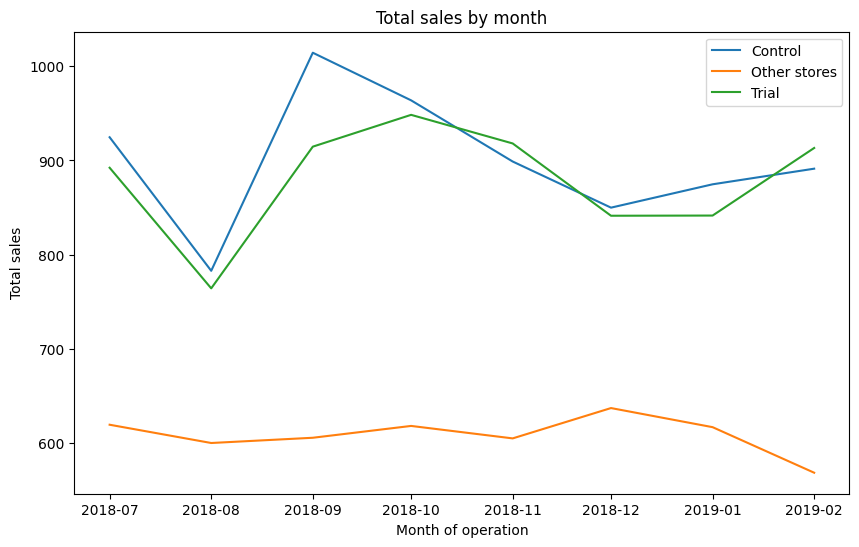

In [29]:
# Create a copy of the DataFrame
measureOverTimeSales = measureOverTime
measureOverTimeSales_copy = measureOverTime

# Assign Store_type based on trial_store and control_store
measureOverTimeSales_copy['Store_type'] = 'Other stores'
measureOverTimeSales_copy.loc[measureOverTimeSales_copy['STORE_NBR'] == trial_store, 'Store_type'] = 'Trial'
measureOverTimeSales_copy.loc[measureOverTimeSales_copy['STORE_NBR'] == control_store, 'Store_type'] = 'Control'

# Calculate mean total sales by YEARMONTH and Store_type
pastSales = measureOverTimeSales_copy.groupby(['YEARMONTH', 'Store_type'])['totSales'].mean().reset_index()

# Convert YEARMONTH to a readable date format
pastSales['TransactionMonth'] = pd.to_datetime(pastSales['YEARMONTH'], format='%Y%m')

# Filter data for dates before March 2019 (201903)
pastSales = pastSales[pastSales['YEARMONTH'] < 201903]

# Plotting the total sales trends
plt.figure(figsize=(10, 6))
for store_type, data in pastSales.groupby('Store_type'):
    plt.plot(data['TransactionMonth'], data['totSales'], label=store_type)

plt.xlabel('Month of operation')
plt.ylabel('Total sales')
plt.title('Total sales by month')
plt.legend()
plt.show()

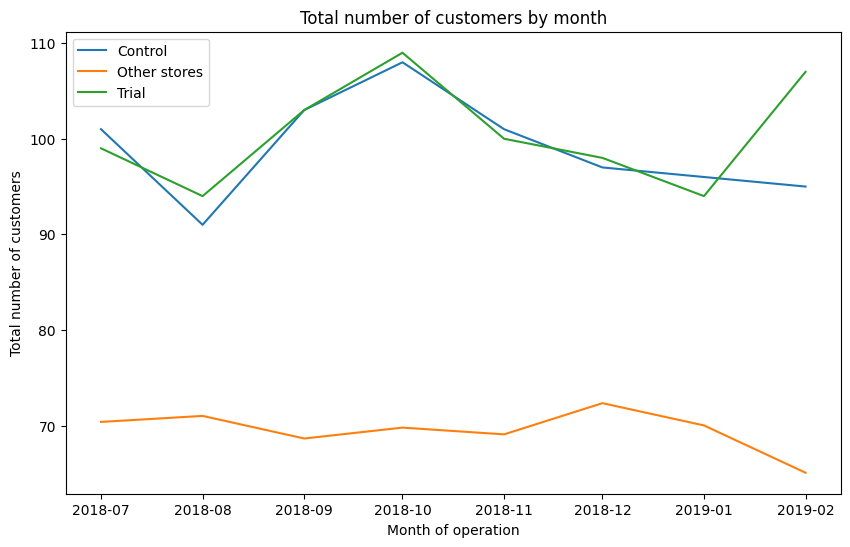

In [30]:
# Next, number of customers.

# Create a copy of the DataFrame
measureOverTimeCusts_copy = measureOverTime

# Assign Store_type based on trial_store and control_store
measureOverTimeCusts_copy['Store_type'] = 'Other stores'
measureOverTimeCusts_copy.loc[measureOverTimeCusts_copy['STORE_NBR'] == trial_store, 'Store_type'] = 'Trial'
measureOverTimeCusts_copy.loc[measureOverTimeCusts_copy['STORE_NBR'] == control_store, 'Store_type'] = 'Control'

# Calculate mean number of customers by YEARMONTH and Store_type
pastCustomers = measureOverTimeCusts_copy.groupby(['YEARMONTH', 'Store_type'])['nCustomers'].mean().reset_index()

# Convert YEARMONTH to a readable date format
pastCustomers['TransactionMonth'] = pd.to_datetime(pastCustomers['YEARMONTH'], format='%Y%m')

# Filter data for dates before March 2019 (201903)
pastCustomers = pastCustomers[pastCustomers['YEARMONTH'] < 201903]

# Plotting the total number of customers trends
plt.figure(figsize=(10, 6))
for store_type, data in pastCustomers.groupby('Store_type'):
    plt.plot(data['TransactionMonth'], data['nCustomers'], label=store_type)

plt.xlabel('Month of operation')
plt.ylabel('Total number of customers')
plt.title('Total number of customers by month')
plt.legend()
plt.show()


The trial period spanned from the beginning of March 2019 to June 2019. To assess any uplift in overall chip sales, I began by scaling the sales of the control store to a level similar to control for any discrepancies between the two stores outside of the trial period.

In [31]:
# Scale pre-trial control sales to match pre-trial trial store sales
scalingFactorForControlSales = (preTrialMeasures[(preTrialMeasures['STORE_NBR'] == trial_store) &
                                               (preTrialMeasures['YEARMONTH'] < 201902)]
                               ['totSales'].sum() /
                               preTrialMeasures[(preTrialMeasures['STORE_NBR'] == control_store) &
                                               (preTrialMeasures['YEARMONTH'] < 201902)]
                               ['totSales'].sum())

# Apply the scaling factor
measureOverTimeSales_copy = measureOverTime
scaledControlSales = (measureOverTimeSales_copy[measureOverTimeSales_copy['STORE_NBR'] == control_store]
                      .assign(controlSales=lambda x: x['totSales'] * scalingFactorForControlSales))
#print(scaledControlSales)

With comparable sales figures established for the control store, I proceeded to calculate the percentage difference between the scaled control sales and the trial store’s sales during the trial period.

In [32]:
# Filter measureOverTimeSales for trial_store and select columns totSales and YEARMONTH
trial_store_data = measureOverTimeSales[measureOverTimeSales['STORE_NBR'] == trial_store][['totSales', 'YEARMONTH']]

# Group by YEARMONTH and calculate percentage difference
trial_store_data_grouped = (trial_store_data.groupby('YEARMONTH')
                            .apply(lambda x: abs(scaledControlSales['controlSales'].values[0] - x['totSales']) /
                                          scaledControlSales['controlSales'].values[0])
                            .reset_index(name='percentageDiff'))
percentageDiff = trial_store_data_grouped

I examined whether the observed difference was statistically significant.

In [33]:
# Calculate Standard Deviation
stdDev = percentageDiff[percentageDiff['YEARMONTH'] < 201902]['percentageDiff'].std()

degreesOfFreedom = 7

# Calculate t-value for hypothesis testing
percentageDiff['tValue'] = (percentageDiff['percentageDiff'] - 0) / stdDev

# Convert YEARMONTH to TransactionMonth and filter for specific time periods
percentageDiff['TransactionMonth'] = pd.to_datetime(percentageDiff['YEARMONTH'] // 100 * 100 + percentageDiff['YEARMONTH'] % 100, format='%Y%m')

# Filter for TransactionMonths between January 2019 and April 2019 and select TransactionMonth and tValue
result = percentageDiff[(percentageDiff['YEARMONTH'] < 201905) & (percentageDiff['YEARMONTH'] > 201901)][['TransactionMonth', 'tValue']]
print(result)

  TransactionMonth    tValue
7       2019-02-01  0.382830
8       2019-03-01  3.054543
9       2019-04-01  1.145879


In [34]:
from scipy.stats import t

# Calculate the 95th percentile of the t-distribution
percentile_95 = t.ppf(0.95, df=degreesOfFreedom)
print(percentile_95)

1.894578605061305


I generated a more visual representation by plotting the sales of the control store, the sales of the trial stores, and the 95th percentile value of sales of the control store.

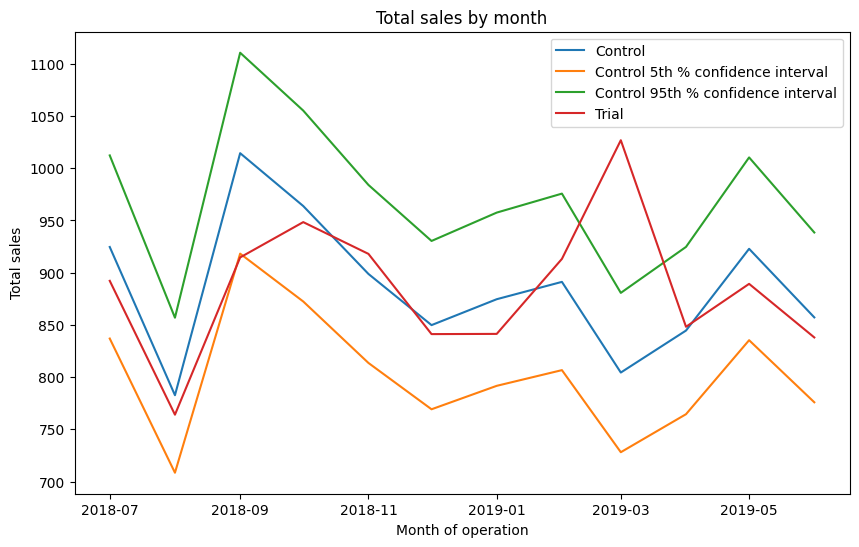

In [35]:
# Copy the measureOverTimeSales DataFrame
measureOverTimeSales = measureOverTime.copy()

# Calculate Store_type (Trial, Control, Other stores) and mean total sales per Store_type by YEARMONTH
measureOverTimeSales['Store_type'] = pd.np.where(measureOverTimeSales['STORE_NBR'] == trial_store, 'Trial',
                                                pd.np.where(measureOverTimeSales['STORE_NBR'] == control_store, 'Control',
                                                            'Other stores'))
pastSales = (measureOverTimeSales[measureOverTimeSales['Store_type'].isin(['Trial', 'Control'])]
             .groupby(['YEARMONTH', 'Store_type'])
             ['totSales'].mean().reset_index())

# Convert YEARMONTH to TransactionMonth for plotting
pastSales['TransactionMonth'] = pd.to_datetime(pastSales['YEARMONTH'] // 100 * 100 + pastSales['YEARMONTH'] % 100,
                                               format='%Y%m')

# Calculate 95th percentile and 5th percentile for Control store and add labels
pastSales_Controls95 = pastSales[pastSales['Store_type'] == 'Control'].copy()
pastSales_Controls95['totSales'] = pastSales_Controls95['totSales'] * (1 + stdDev * 2)
pastSales_Controls95['Store_type'] = 'Control 95th % confidence interval'

pastSales_Controls5 = pastSales[pastSales['Store_type'] == 'Control'].copy()
pastSales_Controls5['totSales'] = pastSales_Controls5['totSales'] * (1 - stdDev * 2)
pastSales_Controls5['Store_type'] = 'Control 5th % confidence interval'

# Combine the dataframes
trialAssessment = pd.concat([pastSales, pastSales_Controls95, pastSales_Controls5])

# Plotting using Matplotlib
plt.figure(figsize=(10, 6))

# Plot lines for different Store_type
for store_type, data in trialAssessment.groupby('Store_type'):
    plt.plot(data['TransactionMonth'], data['totSales'], label=store_type)

# Highlight the period from January 2019 to April 2019
plt.axvspan(pd.Timestamp('2019-01-01'), pd.Timestamp('2019-05-01'), ymin=0, ymax=float('inf'), color='gray', alpha=0.2)

# Customize plot
plt.xlabel('Month of operation')
plt.ylabel('Total sales')
plt.title('Total sales by month')
plt.legend()
plt.show()

The analysis indicated that during the trial period, the performance of store 77 significantly differed from its control store. Specifically, the trial store's performance fell outside the 5% to 95% confidence interval of the control store in two out of the three trial months. So, I proceeded to assess this pattern for the number of customers as well.

In [36]:
# Scale pre-trial control customers to match pre-trial trial store customers
scalingFactorForControlCust = (preTrialMeasures[(preTrialMeasures['STORE_NBR'] == trial_store) &
                                                (preTrialMeasures['YEARMONTH'] < 201902)]
                                ['nCustomers'].sum() /
                                preTrialMeasures[(preTrialMeasures['STORE_NBR'] == control_store) &
                                                (preTrialMeasures['YEARMONTH'] < 201902)]
                                ['nCustomers'].sum())

# Apply the scaling factor
measureOverTimeCusts = measureOverTime.copy()
scaledControlCustomers = (measureOverTimeCusts[measureOverTimeCusts['STORE_NBR'] == control_store]
                            .assign(controlCustomers=lambda x: x['nCustomers'] * scalingFactorForControlCust)
                            .assign(Store_type=lambda x: pd.np.where(x['STORE_NBR'] == trial_store, 'Trial',
                                                                      pd.np.where(x['STORE_NBR'] == control_store,
                                                                                  'Control', 'Other stores')))
                         )

# Calculate the percentage difference between scaled control customers and trial customers
percentageDiff = pd.merge(scaledControlCustomers[['YEARMONTH', 'controlCustomers']],
                          measureOverTimeCusts[measureOverTimeCusts['STORE_NBR'] == trial_store]
                            [['YEARMONTH', 'nCustomers']],
                          on='YEARMONTH')
percentageDiff['percentageDiff'] = abs(percentageDiff['controlCustomers'] - percentageDiff['nCustomers']) / percentageDiff['controlCustomers']

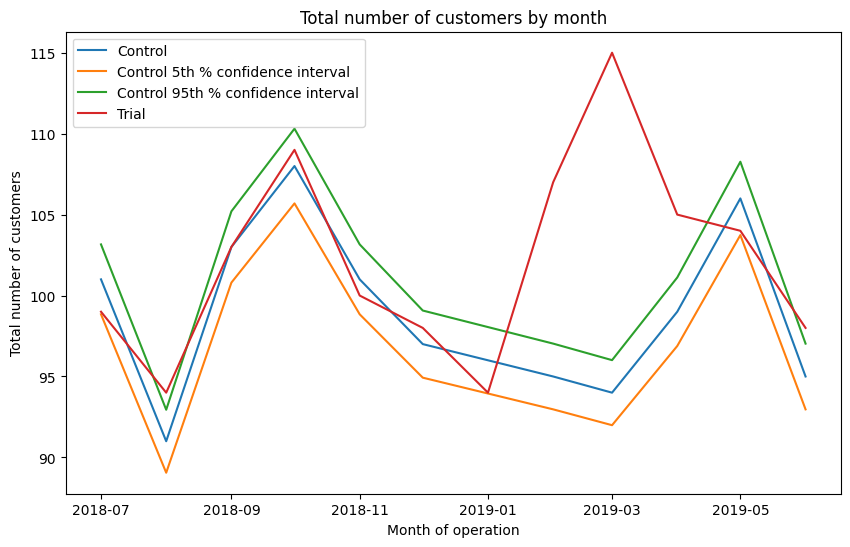

In [37]:
# Calculate standard deviation based on the scaled percentage difference in the pre-trial period
stdDev = percentageDiff[percentageDiff['YEARMONTH'] < 201902]['percentageDiff'].std()

# Set degrees of freedom
degreesOfFreedom = 7

# Copy the measureOverTimeSales DataFrame
measureOverTimeCusts = measureOverTime.copy()

# Calculate Store_type (Trial, Control, Other stores) and mean total sales per Store_type by YEARMONTH
measureOverTimeCusts['Store_type'] = pd.np.where(measureOverTimeCusts['STORE_NBR'] == trial_store, 'Trial',
                                                pd.np.where(measureOverTimeCusts['STORE_NBR'] == control_store, 'Control',
                                                            'Other stores'))
pastCustomers = (measureOverTimeCusts[measureOverTimeCusts['Store_type'].isin(['Trial', 'Control'])]
             .groupby(['YEARMONTH', 'Store_type'])
             ['nCustomers'].mean().reset_index())

# Convert YEARMONTH to TransactionMonth for plotting
pastCustomers['TransactionMonth'] = pd.to_datetime(pastCustomers['YEARMONTH'] // 100 * 100 + pastCustomers['YEARMONTH'] % 100,
                                               format='%Y%m')

# Calculate 95th percentile and 5th percentile for Control store and add labels
pastCustomers_Controls95 = pastCustomers[pastCustomers['Store_type'] == 'Control'].copy()
pastCustomers_Controls95['nCustomers'] = pastCustomers_Controls95['nCustomers'] * (1 + stdDev * 2)
pastCustomers_Controls95['Store_type'] = 'Control 95th % confidence interval'

pastCustomers_Controls5 = pastCustomers[pastCustomers['Store_type'] == 'Control'].copy()
pastCustomers_Controls5['nCustomers'] = pastCustomers_Controls5['nCustomers'] * (1 - stdDev * 2)
pastCustomers_Controls5['Store_type'] = 'Control 5th % confidence interval'

# Combine the dataframes
trialAssessment = pd.concat([pastCustomers, pastCustomers_Controls95, pastCustomers_Controls5])

# Plotting using Matplotlib
plt.figure(figsize=(10, 6))

# Plot lines for different Store_type
for store_type, data in trialAssessment.groupby('Store_type'):
    plt.plot(data['TransactionMonth'], data['nCustomers'], label=store_type)

# Highlight the period from January 2019 to April 2019
plt.axvspan(pd.Timestamp('2019-01-01'), pd.Timestamp('2019-05-01'), ymin=0, ymax=float('inf'), color='gray', alpha=0.2)

# Customize plot
plt.xlabel('Month of operation')
plt.ylabel('Total number of customers')
plt.title('Total number of customers by month')
plt.legend()
plt.show()

### Trial_store 88

In [103]:
# Define the trial store number
trial_store = 88

# Calculate correlation for total sales (totSales)
corr_nSales = calculate_correlation(preTrialMeasures, 'totSales', trial_store)

# Calculate correlation for number of customers (nCustomers)
corr_nCustomers = calculate_correlation(preTrialMeasures, 'nCustomers', trial_store)

# Calculate magnitude distance for total sales (totSales)
magnitude_nSales = calculate_magnitude_distance(preTrialMeasures, 'totSales', trial_store)

# Calculate magnitude distance for number of customers (nCustomers)
magnitude_nCustomers = calculate_magnitude_distance(preTrialMeasures, 'nCustomers', trial_store)

print('corr_nsales : ',corr_nSales)
print('corr_ncustomers: ',corr_nCustomers)
print('magnitude_nSales: ',magnitude_nSales)
print('magnitude_nCustomers: ',magnitude_nCustomers)

corr_nsales :      Store1 Store2  corr_measure
0       88      1      0.813636
1       88      2     -0.067927
2       88      3     -0.507847
3       88      4     -0.745566
4       88      5      0.190330
..     ...    ...           ...
255     88    268     -0.021429
256     88    269     -0.172578
257     88    270     -0.723272
258     88    271     -0.103037
259     88    272     -0.772772

[260 rows x 3 columns]
corr_ncustomers:      Store1 Store2  corr_measure
0       88      1      0.305334
1       88      2     -0.452379
2       88      3      0.522884
3       88      4     -0.361503
4       88      5     -0.025320
..     ...    ...           ...
255     88    268      0.672672
256     88    269     -0.274781
257     88    270     -0.103032
258     88    271     -0.018831
259     88    272      0.026909

[260 rows x 3 columns]
magnitude_nSales:       Store1  Store2  mag_measure
0        88       1     0.153935
1        88       2     0.110907
2        88       3     0.920003


I combined all the scores calculated using our function to create a composite score for ranking. I opted for a simple average of the correlation and magnitude scores for each driver. I considered adjusting the weight of the correlation score depending on our emphasis—increasing the weight for trend similarity or decreasing it for the absolute size of the drivers.

In [104]:
# Define the weights for correlation and magnitude
corr_weight = 0.5

# Merge correlation and magnitude DataFrames for total sales (totSales)
score_nSales = pd.merge(corr_nSales, magnitude_nSales, on=['Store1', 'Store2'])
score_nSales['scoreNSales'] = score_nSales['corr_measure'] * corr_weight + score_nSales['mag_measure'] * (1 - corr_weight)

# Merge correlation and magnitude DataFrames for number of customers (nCustomers)
score_nCustomers = pd.merge(corr_nCustomers, magnitude_nCustomers, on=['Store1', 'Store2'])
score_nCustomers['scoreNCust'] = score_nCustomers['corr_measure'] * corr_weight + score_nCustomers['mag_measure'] * (1 - corr_weight)
print(score_nCustomers)

    Store1 Store2  corr_measure  mag_measure  scoreNCust
0       88      1      0.305334     0.370079    0.337706
1       88      2     -0.452379     0.291339   -0.080520
2       88      3      0.522884     0.866142    0.694513
3       88      4     -0.361503     0.992126    0.315312
4       88      5     -0.025320     0.716535    0.345608
..     ...    ...           ...          ...         ...
255     88    268      0.672672     0.362205    0.517438
256     88    269     -0.274781     0.795276    0.260247
257     88    270     -0.103032     0.740157    0.318563
258     88    271     -0.018831     0.740157    0.360663
259     88    272      0.026909     0.362205    0.194557

[260 rows x 5 columns]


After obtaining individual scores for both total number of sales and number of customers, I proceeded to merge the two scores by calculating a simple average.

In [105]:
# Merge scores for total sales and number of customers
score_Control = pd.merge(score_nSales, score_nCustomers, on=['Store1', 'Store2'])

# Calculate final combined control score
score_Control['finalControlScore'] = score_Control['scoreNSales'] * 0.5 + score_Control['scoreNCust'] * 0.5
print(score_Control)

    Store1 Store2  corr_measure_x  mag_measure_x  scoreNSales  corr_measure_y  \
0       88      1        0.813636       0.153935     0.483785        0.305334   
1       88      2       -0.067927       0.110907     0.021490       -0.452379   
2       88      3       -0.507847       0.920003     0.206078        0.522884   
3       88      4       -0.745566       0.931048     0.092741       -0.361503   
4       88      5        0.190330       0.618040     0.404185       -0.025320   
..     ...    ...             ...            ...          ...             ...   
255     88    268       -0.021429       0.167050     0.072811        0.672672   
256     88    269       -0.172578       0.748428     0.287925       -0.274781   
257     88    270       -0.723272       0.733701     0.005215       -0.103032   
258     88    271       -0.103037       0.728946     0.312954       -0.018831   
259     88    272       -0.772772       0.327428    -0.222672        0.026909   

     mag_measure_y  scoreNC

The store with the highest score is chosen as the control store because it exhibits the highest similarity to the trial store.

In [116]:
# Filter the scores for the trial store

trial_store_scores = score_Control[score_Control['Store1'] == trial_store]

# Sort the scores in descending order of finalControlScore and select the second-highest store
control_store = trial_store_scores.sort_values(by='finalControlScore', ascending=False)['Store2'].iloc[1]
print(control_store)

178


Having found a control store, I proceeded to visually check if the drivers were indeed similar in the period before the trial. The initial focus was on examining the total sales during this period.

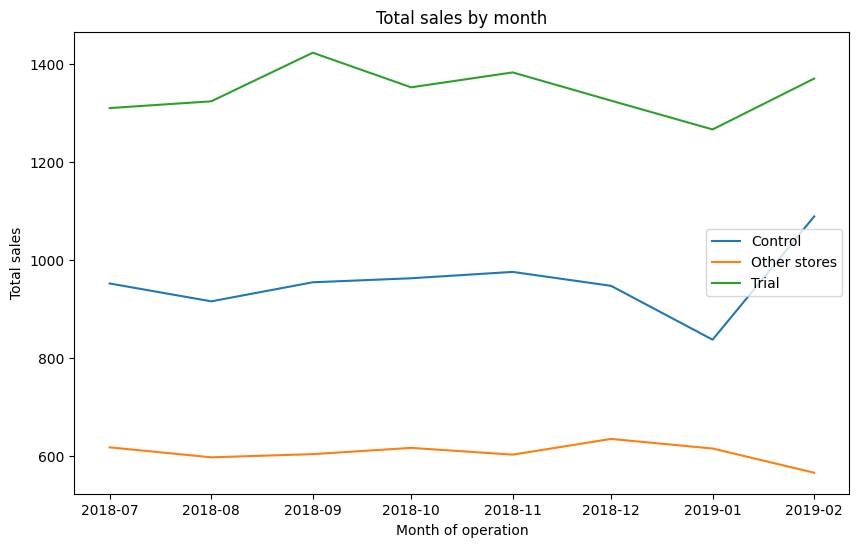

In [107]:
# Create a copy of the DataFrame
measureOverTimeSales = measureOverTime
measureOverTimeSales_copy = measureOverTime

# Assign Store_type based on trial_store and control_store
measureOverTimeSales_copy['Store_type'] = 'Other stores'
measureOverTimeSales_copy.loc[measureOverTimeSales_copy['STORE_NBR'] == trial_store, 'Store_type'] = 'Trial'
measureOverTimeSales_copy.loc[measureOverTimeSales_copy['STORE_NBR'] == control_store, 'Store_type'] = 'Control'

# Calculate mean total sales by YEARMONTH and Store_type
pastSales = measureOverTimeSales_copy.groupby(['YEARMONTH', 'Store_type'])['totSales'].mean().reset_index()

# Convert YEARMONTH to a readable date format
pastSales['TransactionMonth'] = pd.to_datetime(pastSales['YEARMONTH'], format='%Y%m')

# Filter data for dates before March 2019 (201903)
pastSales = pastSales[pastSales['YEARMONTH'] < 201903]

# Plotting the total sales trends
plt.figure(figsize=(10, 6))
for store_type, data in pastSales.groupby('Store_type'):
    plt.plot(data['TransactionMonth'], data['totSales'], label=store_type)

plt.xlabel('Month of operation')
plt.ylabel('Total sales')
plt.title('Total sales by month')
plt.legend()
plt.show()

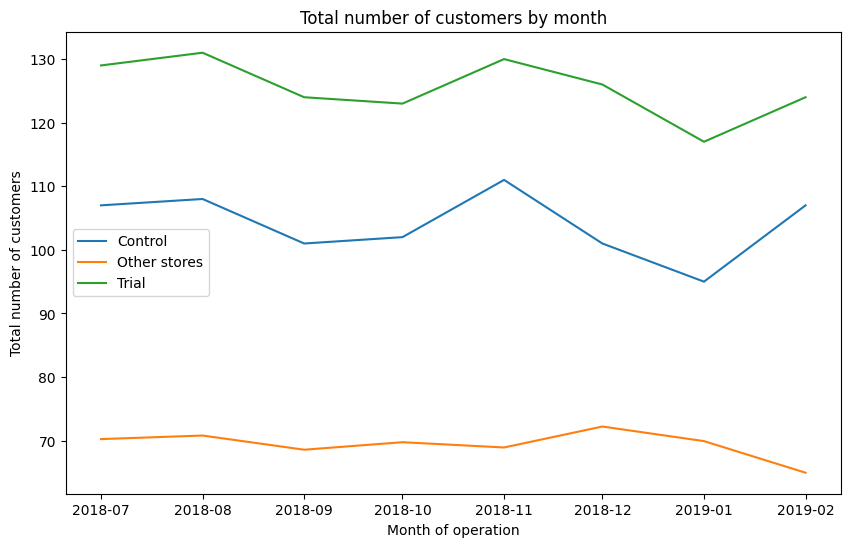

In [108]:
# Next, number of customers.

# Create a copy of the DataFrame
measureOverTimeCusts_copy = measureOverTime

# Assign Store_type based on trial_store and control_store
measureOverTimeCusts_copy['Store_type'] = 'Other stores'
measureOverTimeCusts_copy.loc[measureOverTimeCusts_copy['STORE_NBR'] == trial_store, 'Store_type'] = 'Trial'
measureOverTimeCusts_copy.loc[measureOverTimeCusts_copy['STORE_NBR'] == control_store, 'Store_type'] = 'Control'

# Calculate mean number of customers by YEARMONTH and Store_type
pastCustomers = measureOverTimeCusts_copy.groupby(['YEARMONTH', 'Store_type'])['nCustomers'].mean().reset_index()

# Convert YEARMONTH to a readable date format
pastCustomers['TransactionMonth'] = pd.to_datetime(pastCustomers['YEARMONTH'], format='%Y%m')

# Filter data for dates before March 2019 (201903)
pastCustomers = pastCustomers[pastCustomers['YEARMONTH'] < 201903]

# Plotting the total number of customers trends
plt.figure(figsize=(10, 6))
for store_type, data in pastCustomers.groupby('Store_type'):
    plt.plot(data['TransactionMonth'], data['nCustomers'], label=store_type)

plt.xlabel('Month of operation')
plt.ylabel('Total number of customers')
plt.title('Total number of customers by month')
plt.legend()
plt.show()


The trial period spanned from the beginning of March 2019 to June 2019. To assess any uplift in overall chip sales, I began by scaling the sales of the control store to a level similar to control for any discrepancies between the two stores outside of the trial period.

In [109]:
# Scale pre-trial control sales to match pre-trial trial store sales
scalingFactorForControlSales = (preTrialMeasures[(preTrialMeasures['STORE_NBR'] == trial_store) &
                                               (preTrialMeasures['YEARMONTH'] < 201902)]
                               ['totSales'].sum() /
                               preTrialMeasures[(preTrialMeasures['STORE_NBR'] == control_store) &
                                               (preTrialMeasures['YEARMONTH'] < 201902)]
                               ['totSales'].sum())

# Apply the scaling factor
measureOverTimeSales_copy = measureOverTime
scaledControlSales = (measureOverTimeSales_copy[measureOverTimeSales_copy['STORE_NBR'] == control_store]
                      .assign(controlSales=lambda x: x['totSales'] * scalingFactorForControlSales))
#print(scaledControlSales)

With comparable sales figures established for the control store, I proceeded to calculate the percentage difference between the scaled control sales and the trial store’s sales during the trial period.

In [110]:
# Filter measureOverTimeSales for trial_store and select columns totSales and YEARMONTH
trial_store_data = measureOverTimeSales[measureOverTimeSales['STORE_NBR'] == trial_store][['totSales', 'YEARMONTH']]

# Group by YEARMONTH and calculate percentage difference
trial_store_data_grouped = (trial_store_data.groupby('YEARMONTH')
                            .apply(lambda x: abs(scaledControlSales['controlSales'].values[0] - x['totSales']) /
                                          scaledControlSales['controlSales'].values[0])
                            .reset_index(name='percentageDiff'))
percentageDiff = trial_store_data_grouped

I examined whether the observed difference was statistically significant.

In [111]:
# Calculate Standard Deviation
stdDev = percentageDiff[percentageDiff['YEARMONTH'] < 201902]['percentageDiff'].std()

degreesOfFreedom = 7

# Calculate t-value for hypothesis testing
percentageDiff['tValue'] = (percentageDiff['percentageDiff'] - 0) / stdDev

# Convert YEARMONTH to TransactionMonth and filter for specific time periods
percentageDiff['TransactionMonth'] = pd.to_datetime(percentageDiff['YEARMONTH'] // 100 * 100 + percentageDiff['YEARMONTH'] % 100, format='%Y%m')

# Filter for TransactionMonths between January 2019 and April 2019 and select TransactionMonth and tValue
result = percentageDiff[(percentageDiff['YEARMONTH'] < 201905) & (percentageDiff['YEARMONTH'] > 201901)][['TransactionMonth', 'tValue']]
print(result)

  TransactionMonth    tValue
7       2019-02-01  0.181091
8       2019-03-01  3.901343
9       2019-04-01  2.587086


In [112]:
from scipy.stats import t

# Calculate the 95th percentile of the t-distribution
percentile_95 = t.ppf(0.95, df=degreesOfFreedom)
print(percentile_95)

1.894578605061305


I generated a more visual representation by plotting the sales of the control store, the sales of the trial stores, and the 95th percentile value of sales of the control store.

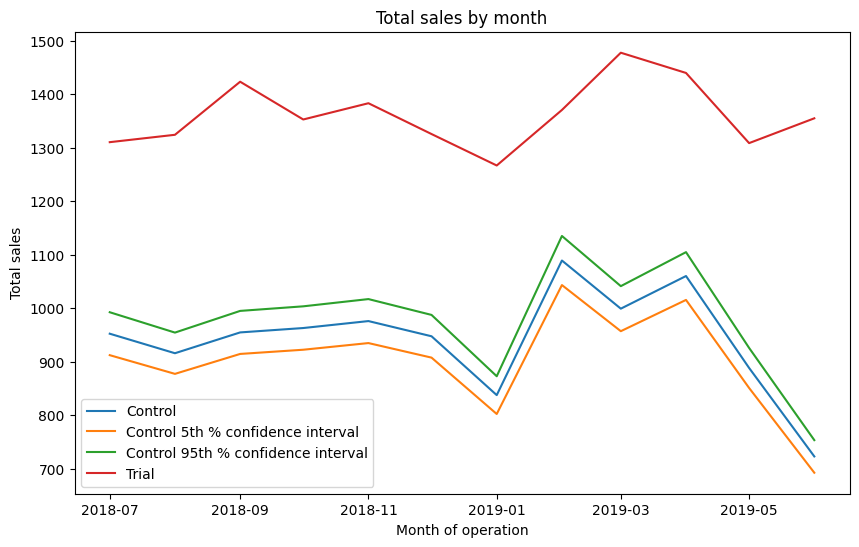

In [113]:
# Copy the measureOverTimeSales DataFrame
measureOverTimeSales = measureOverTime.copy()

# Calculate Store_type (Trial, Control, Other stores) and mean total sales per Store_type by YEARMONTH
measureOverTimeSales['Store_type'] = pd.np.where(measureOverTimeSales['STORE_NBR'] == trial_store, 'Trial',
                                                pd.np.where(measureOverTimeSales['STORE_NBR'] == control_store, 'Control',
                                                            'Other stores'))
pastSales = (measureOverTimeSales[measureOverTimeSales['Store_type'].isin(['Trial', 'Control'])]
             .groupby(['YEARMONTH', 'Store_type'])
             ['totSales'].mean().reset_index())

# Convert YEARMONTH to TransactionMonth for plotting
pastSales['TransactionMonth'] = pd.to_datetime(pastSales['YEARMONTH'] // 100 * 100 + pastSales['YEARMONTH'] % 100,
                                               format='%Y%m')

# Calculate 95th percentile and 5th percentile for Control store and add labels
pastSales_Controls95 = pastSales[pastSales['Store_type'] == 'Control'].copy()
pastSales_Controls95['totSales'] = pastSales_Controls95['totSales'] * (1 + stdDev * 2)
pastSales_Controls95['Store_type'] = 'Control 95th % confidence interval'

pastSales_Controls5 = pastSales[pastSales['Store_type'] == 'Control'].copy()
pastSales_Controls5['totSales'] = pastSales_Controls5['totSales'] * (1 - stdDev * 2)
pastSales_Controls5['Store_type'] = 'Control 5th % confidence interval'

# Combine the dataframes
trialAssessment = pd.concat([pastSales, pastSales_Controls95, pastSales_Controls5])

# Plotting using Matplotlib
plt.figure(figsize=(10, 6))

# Plot lines for different Store_type
for store_type, data in trialAssessment.groupby('Store_type'):
    plt.plot(data['TransactionMonth'], data['totSales'], label=store_type)

# Highlight the period from January 2019 to April 2019
plt.axvspan(pd.Timestamp('2019-01-01'), pd.Timestamp('2019-05-01'), ymin=0, ymax=float('inf'), color='gray', alpha=0.2)

# Customize plot
plt.xlabel('Month of operation')
plt.ylabel('Total sales')
plt.title('Total sales by month')
plt.legend()
plt.show()

The analysis indicated that during the trial period, the performance of store 77 significantly differed from its control store. Specifically, the trial store's performance fell outside the 5% to 95% confidence interval of the control store in two out of the three trial months. So, I proceeded to assess this pattern for the number of customers as well.

In [114]:
# Scale pre-trial control customers to match pre-trial trial store customers
scalingFactorForControlCust = (preTrialMeasures[(preTrialMeasures['STORE_NBR'] == trial_store) &
                                                (preTrialMeasures['YEARMONTH'] < 201902)]
                                ['nCustomers'].sum() /
                                preTrialMeasures[(preTrialMeasures['STORE_NBR'] == control_store) &
                                                (preTrialMeasures['YEARMONTH'] < 201902)]
                                ['nCustomers'].sum())

# Apply the scaling factor
measureOverTimeCusts = measureOverTime.copy()
scaledControlCustomers = (measureOverTimeCusts[measureOverTimeCusts['STORE_NBR'] == control_store]
                            .assign(controlCustomers=lambda x: x['nCustomers'] * scalingFactorForControlCust)
                            .assign(Store_type=lambda x: pd.np.where(x['STORE_NBR'] == trial_store, 'Trial',
                                                                      pd.np.where(x['STORE_NBR'] == control_store,
                                                                                  'Control', 'Other stores')))
                         )

# Calculate the percentage difference between scaled control customers and trial customers
percentageDiff = pd.merge(scaledControlCustomers[['YEARMONTH', 'controlCustomers']],
                          measureOverTimeCusts[measureOverTimeCusts['STORE_NBR'] == trial_store]
                            [['YEARMONTH', 'nCustomers']],
                          on='YEARMONTH')
percentageDiff['percentageDiff'] = abs(percentageDiff['controlCustomers'] - percentageDiff['nCustomers']) / percentageDiff['controlCustomers']

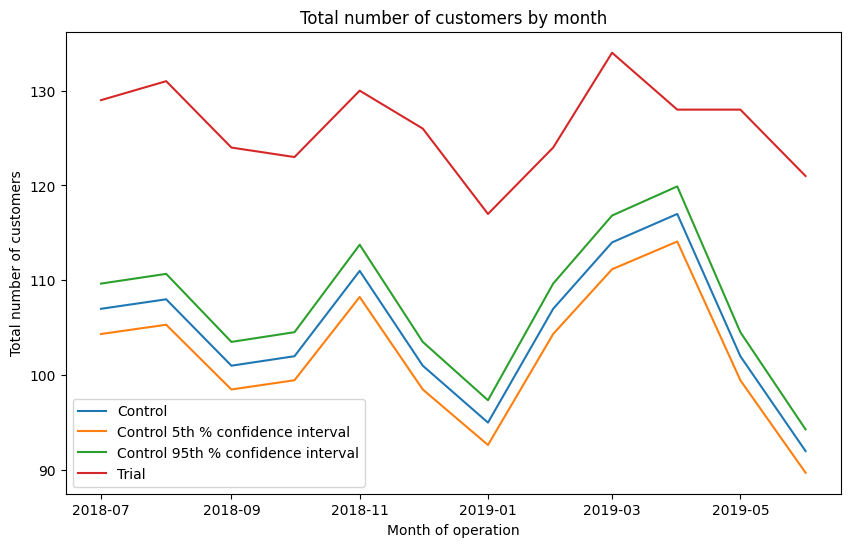

In [115]:
# Calculate standard deviation based on the scaled percentage difference in the pre-trial period
stdDev = percentageDiff[percentageDiff['YEARMONTH'] < 201902]['percentageDiff'].std()

# Set degrees of freedom
degreesOfFreedom = 7

# Copy the measureOverTimeSales DataFrame
measureOverTimeCusts = measureOverTime.copy()

# Calculate Store_type (Trial, Control, Other stores) and mean total sales per Store_type by YEARMONTH
measureOverTimeCusts['Store_type'] = pd.np.where(measureOverTimeCusts['STORE_NBR'] == trial_store, 'Trial',
                                                pd.np.where(measureOverTimeCusts['STORE_NBR'] == control_store, 'Control',
                                                            'Other stores'))
pastCustomers = (measureOverTimeCusts[measureOverTimeCusts['Store_type'].isin(['Trial', 'Control'])]
             .groupby(['YEARMONTH', 'Store_type'])
             ['nCustomers'].mean().reset_index())

# Convert YEARMONTH to TransactionMonth for plotting
pastCustomers['TransactionMonth'] = pd.to_datetime(pastCustomers['YEARMONTH'] // 100 * 100 + pastCustomers['YEARMONTH'] % 100,
                                               format='%Y%m')

# Calculate 95th percentile and 5th percentile for Control store and add labels
pastCustomers_Controls95 = pastCustomers[pastCustomers['Store_type'] == 'Control'].copy()
pastCustomers_Controls95['nCustomers'] = pastCustomers_Controls95['nCustomers'] * (1 + stdDev * 2)
pastCustomers_Controls95['Store_type'] = 'Control 95th % confidence interval'

pastCustomers_Controls5 = pastCustomers[pastCustomers['Store_type'] == 'Control'].copy()
pastCustomers_Controls5['nCustomers'] = pastCustomers_Controls5['nCustomers'] * (1 - stdDev * 2)
pastCustomers_Controls5['Store_type'] = 'Control 5th % confidence interval'

# Combine the dataframes
trialAssessment = pd.concat([pastCustomers, pastCustomers_Controls95, pastCustomers_Controls5])

# Plotting using Matplotlib
plt.figure(figsize=(10, 6))

# Plot lines for different Store_type
for store_type, data in trialAssessment.groupby('Store_type'):
    plt.plot(data['TransactionMonth'], data['nCustomers'], label=store_type)

# Highlight the period from January 2019 to April 2019
plt.axvspan(pd.Timestamp('2019-01-01'), pd.Timestamp('2019-05-01'), ymin=0, ymax=float('inf'), color='gray', alpha=0.2)

# Customize plot
plt.xlabel('Month of operation')
plt.ylabel('Total number of customers')
plt.title('Total number of customers by month')
plt.legend()
plt.show()